In [ ]:
# =========================================================
# Predicción de Readmisión por Diabetes (en 30 días)
# Ciclo completo de Machine Learning con diabetic_data.csv
# =========================================================

# ==============================
# 1) Librerías e Importaciones
# ==============================
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, classification_report
)

import joblib, json

# ==============================
# 2) Carga del Dataset
# ==============================
DATA_PATH = "C:/Users/lupit/Downloads/diabetic_data.csv"
df_raw = pd.read_csv(DATA_PATH)

print("Dimensiones:", df_raw.shape)
display(df_raw.head())
display(df_raw.tail())
display(df_raw.dtypes)


Dimensiones: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [2]:
# ============================================
# 3) Limpieza inicial y definición de objetivo
# ============================================
df = df_raw.copy()

# Reemplazamos marcadores típicos de "desconocido" por NaN para poder imputar
df.replace(['?', 'Unknown', 'unknown', 'UNK', 'None', 'NONE', 'NaN', 'nan'], np.nan, inplace=True)

# El dataset de UCI suele tener 'readmitted' con valores: '<30', '>30', 'NO'
# Mapeamos a binario: 1 si '<30', 0 en caso contrario
if 'readmitted' in df.columns:
    df['readmitted_30d'] = (df['readmitted'].astype(str).str.strip().str.upper() == '<30').astype(int)
elif 'readmitted_30d' in df.columns:
    # Ya existe binaria
    df['readmitted_30d'] = df['readmitted_30d'].astype(int)
else:
    raise ValueError("No se encontró columna objetivo. Debe existir 'readmitted' o 'readmitted_30d'.")

target_col = 'readmitted_30d'

# Eliminamos IDs si existen (no aportan al modelo)
for id_col in ['encounter_id', 'patient_nbr']:
    if id_col in df.columns:
        df.drop(columns=id_col, inplace=True)

# Confirmamos distribución de clases
print("Distribución de la clase (conteo):")
display(df[target_col].value_counts())
print("Distribución de la clase (%):")
display((df[target_col].value_counts(normalize=True)*100).round(2))


Distribución de la clase (conteo):


readmitted_30d
0    90409
1    11357
Name: count, dtype: int64

Distribución de la clase (%):


readmitted_30d
0    88.84
1    11.16
Name: proportion, dtype: float64

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    3197 non-null    object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                61510 non-null   object
 9   medical_specialty         51817 non-null   object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-n

,count,mean,std,min,25%,50%,75%,max
admission_type_id,101766.0,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0



Descripción (categóricas):


,count,unique,top,freq
race,99493,5,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
weight,3197,9,[75-100),1336
payer_code,61510,17,MC,32439
medical_specialty,51817,72,InternalMedicine,14635
diag_1,101745,716,428,6862
diag_2,101408,748,276,6752
diag_3,100343,789,250,11555
max_glu_serum,5346,3,Norm,2597


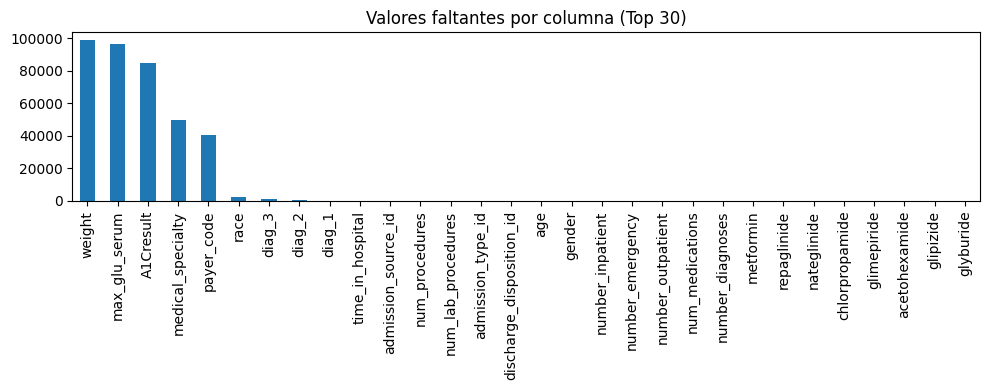

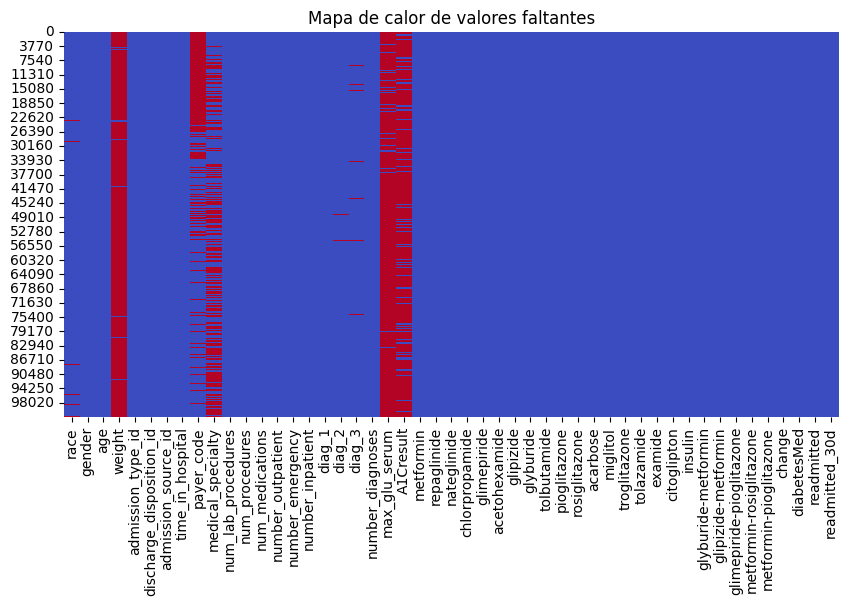

In [ ]:
# ============================
# 4) EDA — Exploración de datos
# ============================

print("Información general:")
df.info()

print("\nDescripción estadística (numéricas):")
display(df.describe(include=[np.number]).T)

print("\nDescripción (categóricas):")
display(df.describe(include=['object']).T)

# ---- Valores faltantes
plt.figure(figsize=(10,4))
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts.head(30).plot(kind='bar')
plt.title("Valores faltantes por columna (Top 30)")
plt.tight_layout()
plt.show()

# Mapa de calor de faltantes (si hay nulos)
if df.isnull().sum().sum() > 0:
    plt.figure(figsize=(10,5))
    sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm')
    plt.title("Mapa de calor de valores faltantes")
    plt.show()
else:
    print(" No hay valores faltantes en el dataset (después de reemplazos).")


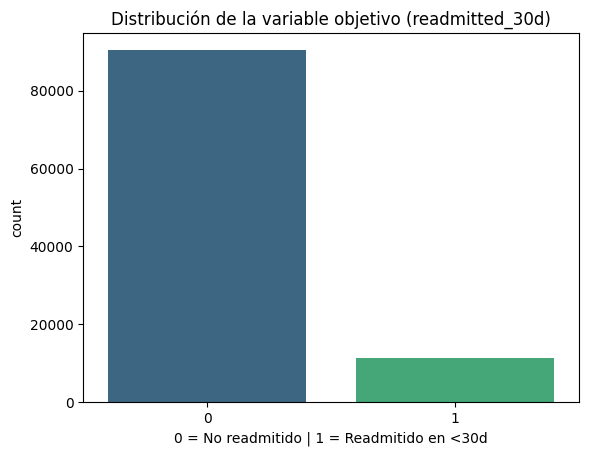

In [4]:
# =========================================
# 4.1) Distribución de la variable objetivo
# =========================================
sns.countplot(x=target_col, data=df, palette='viridis')
plt.title("Distribución de la variable objetivo (readmitted_30d)")
plt.xlabel("0 = No readmitido | 1 = Readmitido en <30d")
plt.show()


Columnas numéricas: 11
Columnas categóricas: 37


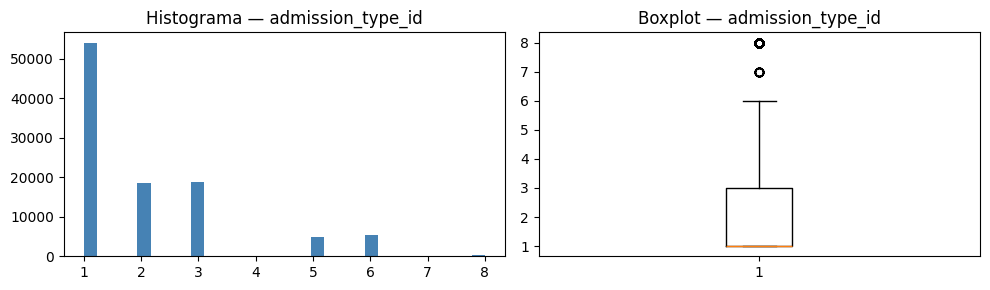

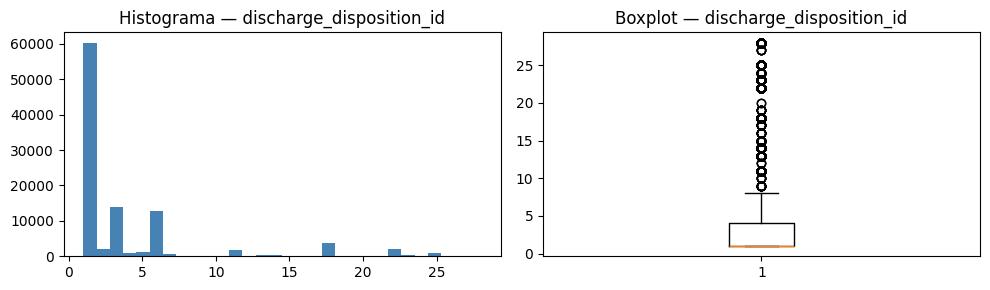

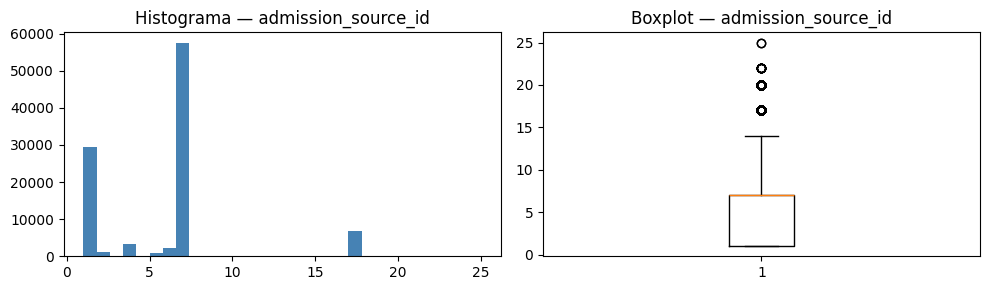

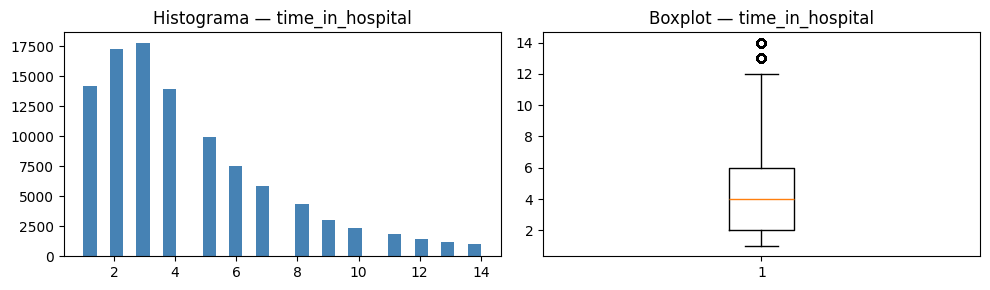

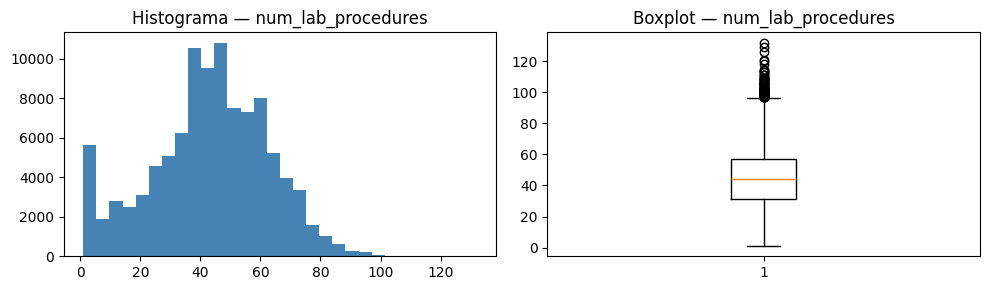

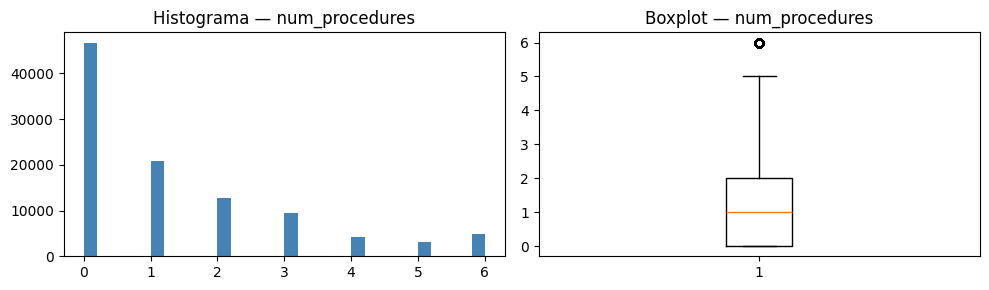

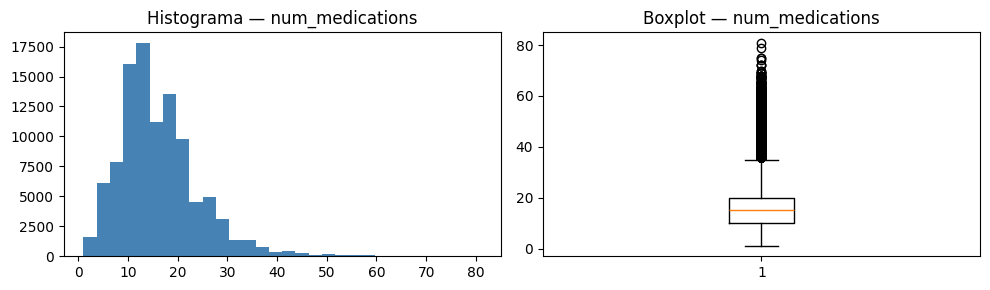

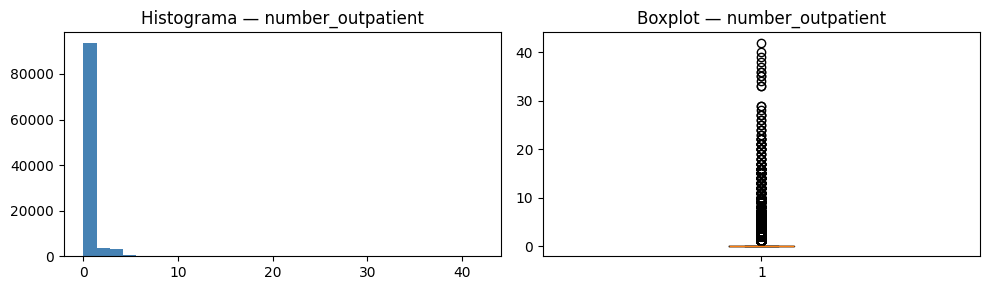

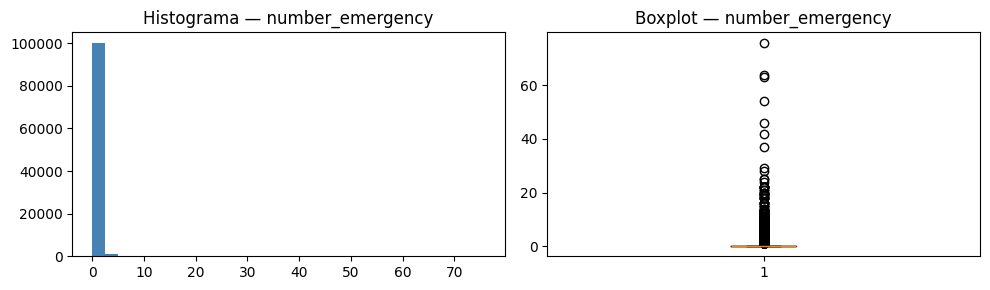

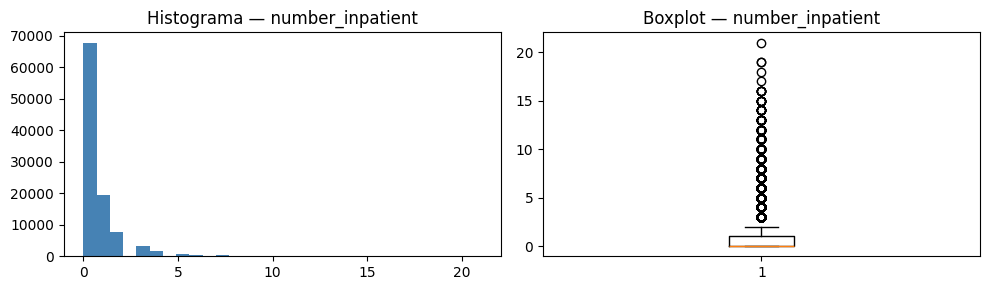

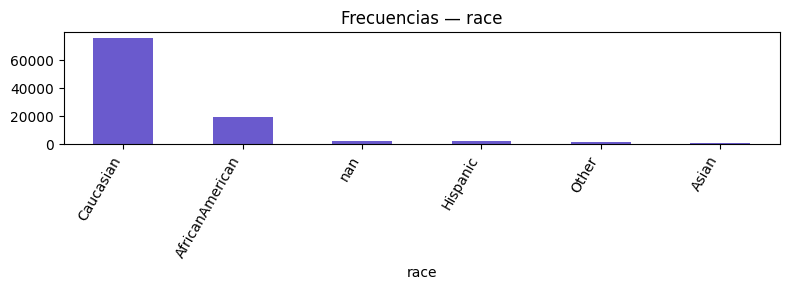

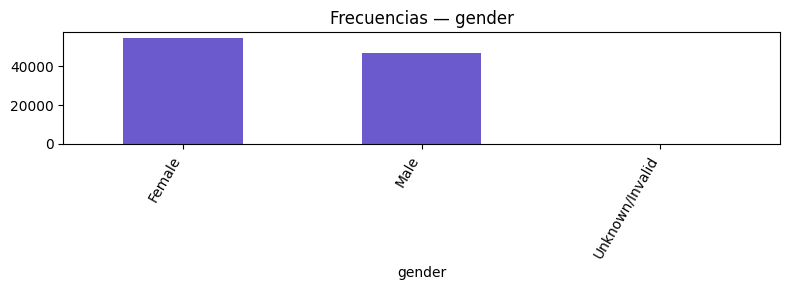

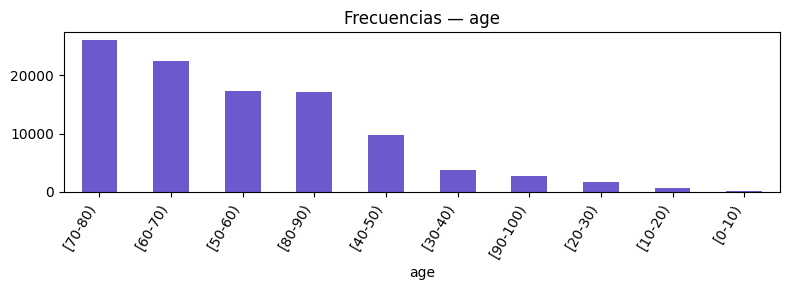

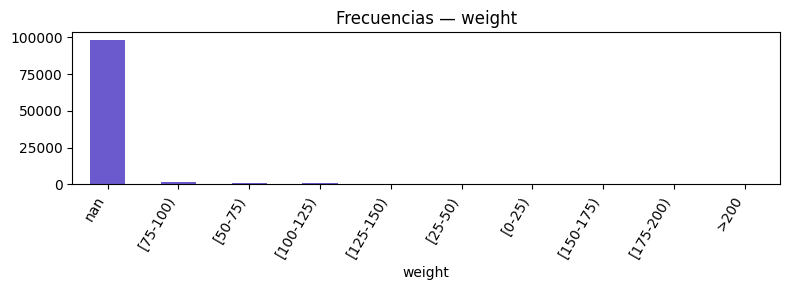

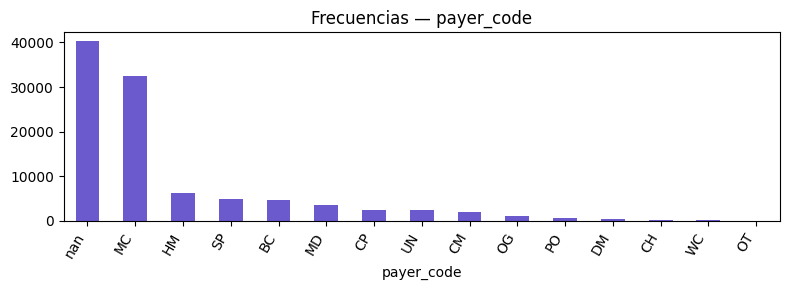

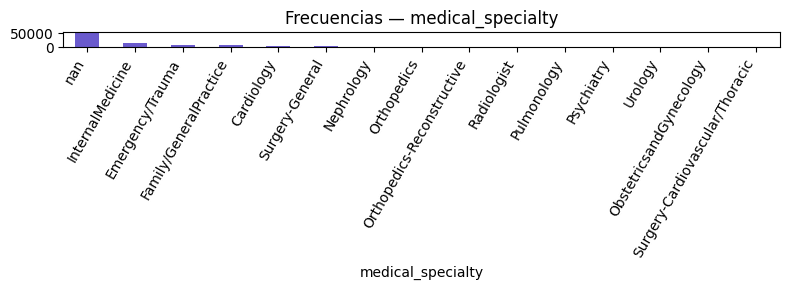

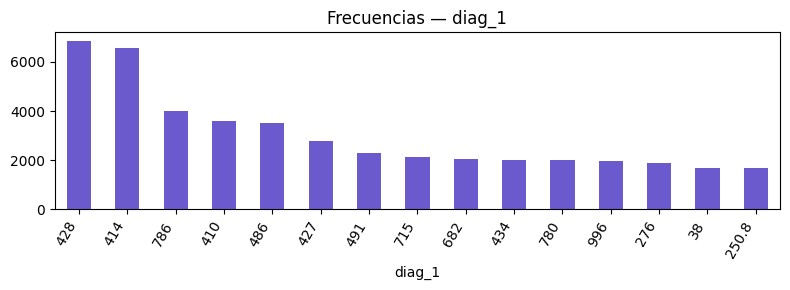

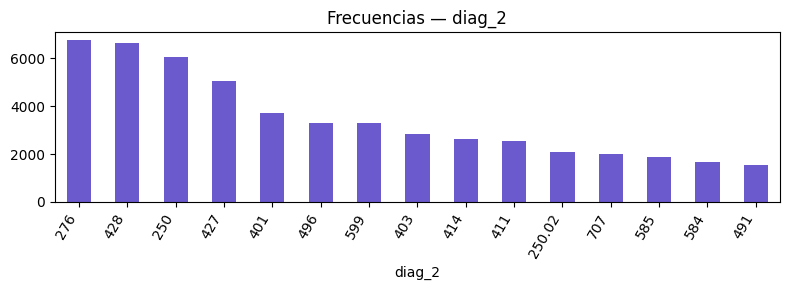

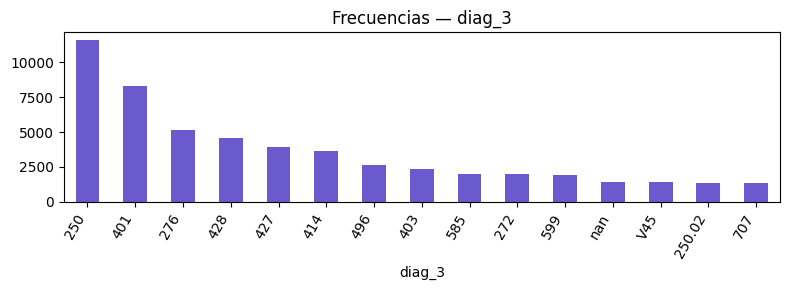

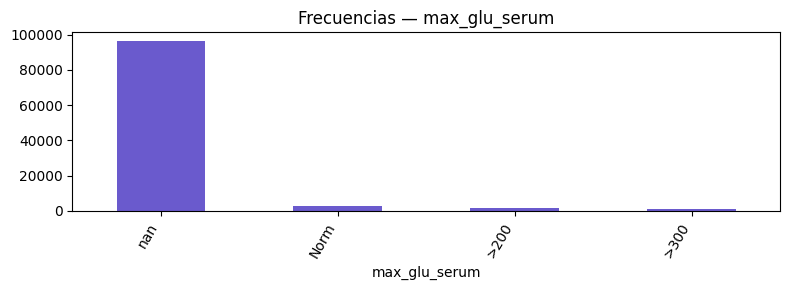

In [5]:
# ===============================================
# 4.2) Distribución de variables numéricas/categóricas
# ===============================================
feature_cols = [c for c in df.columns if c != target_col]
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df[c])]

print(f"Columnas numéricas: {len(num_cols)}")
print(f"Columnas categóricas: {len(cat_cols)}")

# Histogramas y boxplots para algunas numéricas (muestra 10 por brevedad)
for col in num_cols[:10]:
    fig, axes = plt.subplots(1, 2, figsize=(10,3))
    axes[0].hist(df[col].dropna(), bins=30, color='steelblue')
    axes[0].set_title(f"Histograma — {col}")
    axes[1].boxplot(df[col].dropna(), vert=True)
    axes[1].set_title(f"Boxplot — {col}")
    plt.tight_layout()
    plt.show()

# Barras para algunas categóricas (muestra 10 por brevedad)
for col in cat_cols[:10]:
    counts = df[col].value_counts(dropna=False).head(15)
    plt.figure(figsize=(8,3))
    counts.plot(kind='bar', color='slateblue')
    plt.title(f"Frecuencias — {col}")
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()


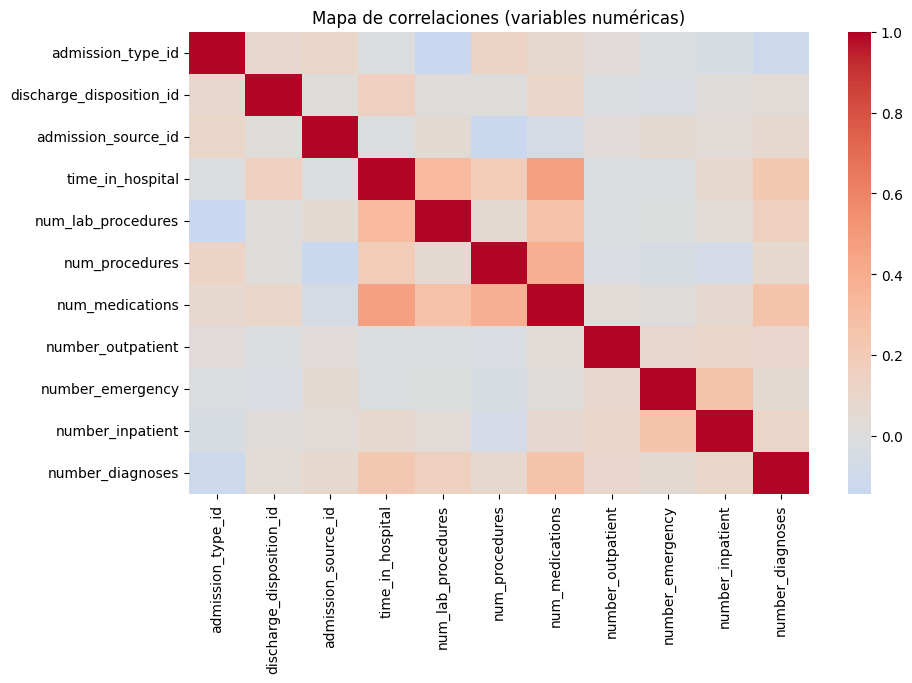

In [6]:
# ===============================
# 4.3) Correlación (numéricas)
# ===============================
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Mapa de correlaciones (variables numéricas)")
    plt.show()
else:
    print("No hay suficientes columnas numéricas para calcular correlaciones.")


In [ ]:
# ==========================================
# 5) Preprocesamiento y Train/Test Split
# ==========================================
X = df[feature_cols].copy()
y = df[target_col].copy()

# División estratificada para mantener proporción de la clase
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   
    ("scaler", StandardScaler())                    
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("onehot", OneHotEncoder(handle_unknown="ignore"))    
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

print("Preprocesamiento configurado.")


✅ Preprocesamiento configurado.


In [ ]:
# ==========================================
# 6) Entrenamiento de modelos (basales)
# ==========================================
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "K-Vecinos (KNN)": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42)
}

results = {}
fitted_pipes = {}

for name, model in models.items():
    print(f"Entrenando: {name}")
    pipe = Pipeline(steps=[("pre", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    fitted_pipes[name] = pipe

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}

results_df = pd.DataFrame(results).T.sort_values(by="F1", ascending=False)
print("\n Resultados basales:")
display(results_df)


Entrenando: Regresión Logística
Entrenando: K-Vecinos (KNN)
Entrenando: RandomForest

📊 Resultados basales:


,Accuracy,Precision,Recall,F1,AUC
Regresión Logística,1.000000,1.000000,1.000000,1.000000,1.00000
RandomForest,1.000000,1.000000,1.000000,1.000000,1.00000
K-Vecinos (KNN),0.943598,0.970662,0.509908,0.668591,0.95403


In [9]:
# =======================================================
# 7) Ajuste de hiperparámetros (GridSearchCV) — RandomForest
# =======================================================
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

rf_base = Pipeline(steps=[("pre", preprocessor),
                          ("model", RandomForestClassifier(random_state=42))])

grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring="f1",      # F1 suele ser útil si hay desbalance
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
best_pipe = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}


Reporte de Clasificación:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     18083
           1     1.0000    1.0000    1.0000      2271

    accuracy                         1.0000     20354
   macro avg     1.0000    1.0000    1.0000     20354
weighted avg     1.0000    1.0000    1.0000     20354



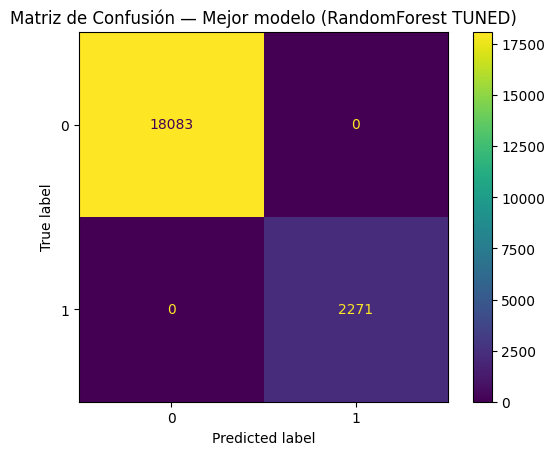

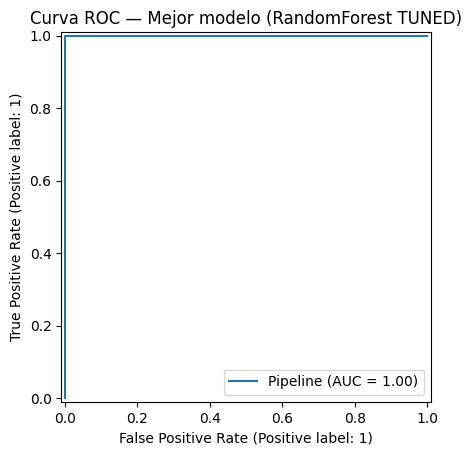

AUC: 1.0


In [10]:
# ==========================================
# 8) Evaluación del mejor modelo (RF TUNED)
# ==========================================
y_pred = best_pipe.predict(X_test)
y_prob = best_pipe.predict_proba(X_test)[:,1]

print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusión — Mejor modelo (RandomForest TUNED)")
plt.show()

# Curva ROC y AUC
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title("Curva ROC — Mejor modelo (RandomForest TUNED)")
plt.show()

print("AUC:", roc_auc_score(y_test, y_prob))


In [ ]:
# ==========================================
# 10) Guardado del modelo (solo .pkl)
# ==========================================
import joblib

# Verificamos qué modelo usar
# Si hiciste GridSearchCV, usa best_pipe (modelo optimizado)
# Si no, usa el RandomForest base entrenado
try:
    final_model = best_pipe
    print(" Se detectó modelo optimizado (GridSearchCV)")
except NameError:
    final_model = fitted_pipes["RandomForest"]
    print(" Usando modelo base (RandomForest)")

# Guardamos el modelo completo (preprocesamiento + entrenamiento)
joblib.dump(final_model, "diabetes_best_pipeline.pkl")

print(" Modelo guardado correctamente en 'diabetes_best_pipeline.pkl'")


✅ Se detectó modelo optimizado (GridSearchCV)
✅ Modelo guardado correctamente en 'diabetes_best_pipeline.pkl'
